# Introduction to the Monte Carlo method

Start by defining the Gibbs distribution:
$$P(\alpha) = e^{-E(\alpha)/kT}$$
this expression, defines the probability of observing a particular configuration of spins, $\alpha$. 
As you can see, the probability of $\alpha$ decays exponentially with increasing energy of $\alpha$, $E(\alpha)$,
where $k$ is the Boltzmann constant, $k = 1.38064852 \times 10^{-23} J/K$
and $T$ is the temperature in Kelvin. 



# What defines the energy of a configuration of spins? 
Given a configuration of spins (e.g., $\uparrow\downarrow\downarrow\uparrow\downarrow$) we can define the energy using the Ising Hamiltonian:

$$ 
\hat{H}' = \sum_{\left<ij\right>}J_{ij}'s_is_j + \sum_i \mu_i' s_i.
$$

However, because the values that we often deal with are small, we can simply divide by the Boltzmann constant to make things simpler to work with:
$$ 
\begin{align}
\hat{H} = \frac{\hat{H}'}{k} =& -\tfrac{1}{k}\sum_{\left<ij\right>} J'_{ij}s_is_j + \tfrac{1}{k}\sum_i\mu_i's_i \\
=& \sum_{\left<ij\right>}J_{ij} s_is_j + \sum_i \mu_i s_i \\
\end{align}
$$

where, $s_i=1$ if the $i^{th}$ spin is `up` and $s_i=-1$ if it is `down`, and the brackets $\left<ij\right>$ indicate a sum over spins that are connected,
and $J_{ij}$ is a coupling constant that determines the energy scale for sites $i$ and $j$. 
The energy here has been divided by the Boltzmann constant to yield units of temperature. 
Let's consider the following case, which has the sites connected in a single 1D line:

$$
\alpha = \uparrow-\downarrow-\downarrow-\uparrow-\downarrow.$$ 

Setting every coupling constant to unity ($J_{ij}=1$) and all local fields to be equal ($\mu_i=\mu$), what is the energy of the following configuration:

$$ 
E(\alpha) = (-1 + 1 - 1 - 1) - \mu = \frac{E(\alpha)'}{k} = \frac{2-\mu'}{k}
$$


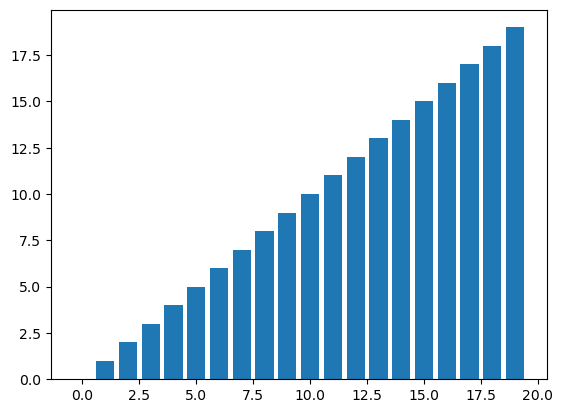

In [1]:
# Load relevant libraries. If you have errors you probably need to install them into your conda env
%matplotlib inline

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import quantum3684.montecarlo as montecarlo
import random
import networkx as nx
import random
import scipy
random.seed(2)

# this is just included to fix a problem with printing later on 
plt.bar(range(20), range(20));
plt.show()



# Define a Hamiltonian (or Graph)

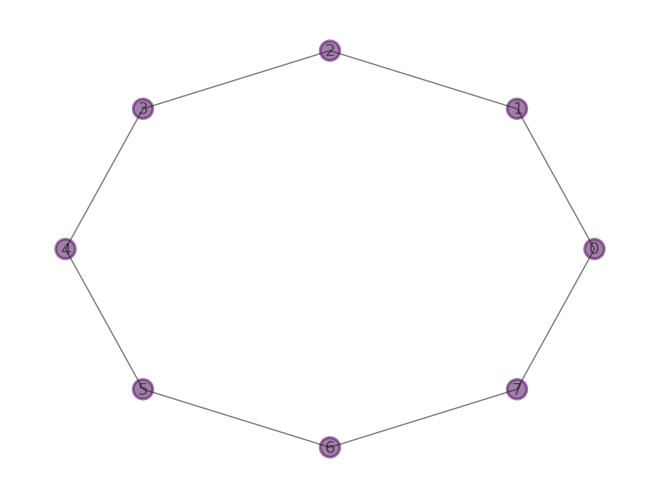

In [2]:
# Number of nodes
N = 8

# Start by setting each edge to -1
Jval = 1

# Create graph
def build_1d_graph(N, Jval):
    """
    Build a 1D graph with a single J value (Jval)
    """
    G = nx.Graph()
    G.add_nodes_from([i for i in range(N)])
    G.add_edges_from([(i,(i+1)% G.number_of_nodes() ) for i in range(N)])
    # G.add_edge(2,5)
    # G.add_edge(4,8)
    # G.add_edge(4,0)
    for e in G.edges:
        G.edges[e]['weight'] = Jval
    return G


def draw_my_graph(G, conf=None, circ=True):
    """
    Draw our graph!
    """
    N = len(G.nodes())
    if conf == None:
        conf = montecarlo.BitString(N=N)
    
    if len(conf.config) != N:
       

        plt.figure(1)
    # nx.draw(G, with_labels=True, font_weight='bold', pos=nx.circular_layout(G))
    
    pos = nx.spring_layout(G)
    if circ==True:
        pos = nx.circular_layout(G)

    # edge_labels = dict([((n1, n2), d['weight'])
    #                     for n1, n2, d in G.edges(data=True)])
    weights = [G[u][v]['weight'] for u,v in G.edges]

    nx.draw(
        G, pos, edge_color='black', 
        # width=2, 
        linewidths=2,
        node_size=200, node_color=conf.config, alpha=.5,
        labels={node: node for node in G.nodes()}, 
        width=weights
    )

    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # plt.figure(2)
    # nx.draw(G, with_labels=True, font_weight='bold')
    plt.show()



# Now let's define a function that converts a graph into a simpler IsingHamiltonian object
def get_IsingHamiltonian(G, mus=None):
    if mus == None:
        mus = np.zeros(len(G.nodes()))

    if len(G.nodes()) != len(mus):
         error("dimensionMismatch")

    if len(G.nodes()) != len(mus):
         error("dimensionMismatch")
         
    J = [[] for i in G.nodes()]
            
    for e in G.edges:
        J[e[0]].append((e[1], G.edges[e]['weight']))
        J[e[1]].append((e[0], G.edges[e]['weight']))
    return montecarlo.IsingHamiltonian(J,mus)

G = build_1d_graph(N, Jval)

# Now Draw the graph. First we will draw it with the nodes arranged on the circle, then we will draw the same graph 
# with the position of the nodes optimized for easier visualization. Let's make a function for this
draw_my_graph(G)

ham = get_IsingHamiltonian(G, mus=[.1 for i in range(N)])

# Create a bitstring

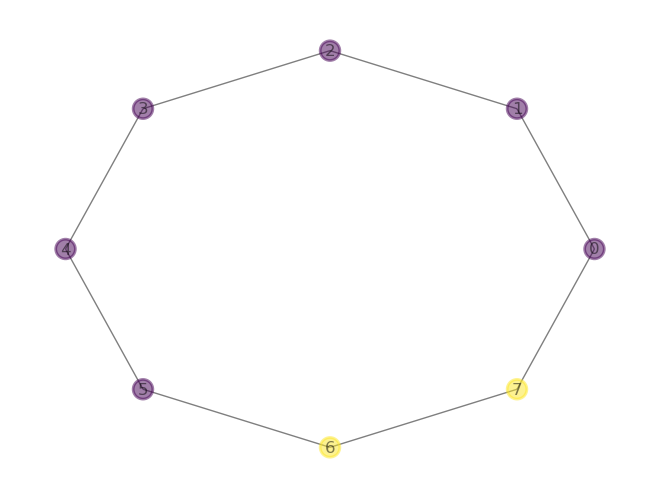

In [3]:
conf = montecarlo.BitString(N=N)
conf.set_config([0, 0, 0, 0, 0, 0, 1, 1])
# conf.initialize(M=2)
draw_my_graph(G,conf=conf)

# Compute the energy

In [4]:
conf.set_config([0, 0, 0, 0, 0, 0, 1, 1])

Ei = ham.energy(conf)
Pi = np.e**(-Ei)
print(" Energy of      ", conf.config, " is ", Ei)
# print(" Probability of ", conf.config, " is ", Pi)
assert(abs(Ei-3.6) < 1e-12)

conf.set_int_config(106, digits=8)
print(" Index 16 = ", conf)
Ei = ham.energy(conf)
print(" Energy of      ", conf.config, " is ", Ei)
assert(abs(Ei+4.0) < 1e-12)



 Energy of       [-1, -1, -1, -1, -1, -1, 1, 1]  is  3.6
 Index 16 =  01101010
 Energy of       [-1, 1, 1, -1, 1, -1, 1, -1]  is  -4.0


# Thermodynamic averages


An expectation value of any quantity, `A`, computed (using the Canonical Ensemble) can be defined as:

$$
\left<A\right> = \frac{1}{Z}\int e^{-E(\alpha)/T}A(\alpha)d\alpha,
$$

where `Z` is referred to as the `partition function`, and is essentially a normalization constant:

$$
Z = \int e^{-E(\alpha)/T}d\alpha,
$$

and

$$
P(\alpha) = \frac{1}{Z}e^{-E(\alpha)/T},
$$

gives the actual statistical weight with which the configuration $\alpha$ occurs in the thermal equilibrium. We now want to consider the discrete case of the formal definitions above. If we are to consider a finite portion of the configuration space it would produces an average of the form:

$$
\left<A\right> = \frac{\sum_\alpha e^{-E'(\alpha)/T}A(\alpha)}{\sum_\alpha e^{-E'(\alpha)/T}}
$$

# Properties

For any fixed state, $\alpha$, the `magnetization` ($M$) is proportional to the _excess_ number of spins pointing up or down while the energy is given by the
Hamiltonian:
$$M(\alpha) = N_{\text{up}}(\alpha) - N_{\text{down}}(\alpha).$$
As a dynamical, fluctuating system, each time you measure the magnetization, the system might be in a different state ($\alpha$) and so you'll get a different number!
However, we already know what the probability of measuring any particular $\alpha$ is, so in order to compute the average magnetization, $\left<M\right>$, we just need to multiply the magnetization of each possible configuration times the probability of it being measured, and then add them all up!
$$ \left<M\right> = \sum_\alpha M(\alpha)P(\alpha).$$
In fact, any average value can be obtained by adding up the value of an individual configuration multiplied by it's probability:
$$ \left<E\right> = \sum_\alpha E(\alpha)P(\alpha).$$

This means that to obtain any average value (also known as an `expectation value`) computationally, we must compute the both the value and probability of all possible configurations. This becomes extremely expensive as the number of spins ($N$) increases. 

000000


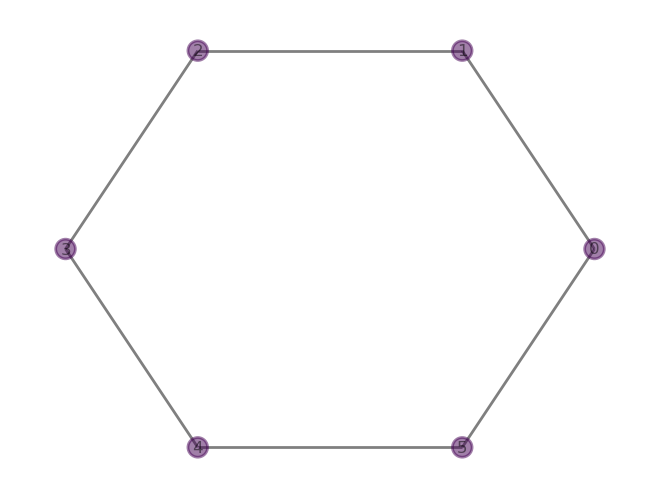

This is the config: [-1, -1, -1, -1, -1, -1]
This is the energy: 5.3999999999999995
This is the Gibbs: 0.00451658094261267
This is the config: [-1, -1, -1, -1, -1, 1]
This is the energy: -0.40000000000000036
This is the Gibbs: 1.4918246976412708
This is the config: [-1, -1, -1, -1, 1, -1]
This is the energy: -0.40000000000000036
This is the Gibbs: 1.4918246976412708
This is the config: [-1, -1, -1, -1, 1, 1]
This is the energy: 1.7999999999999998
This is the Gibbs: 0.16529888822158656
This is the config: [-1, -1, -1, 1, -1, -1]
This is the energy: -0.40000000000000036
This is the Gibbs: 1.4918246976412708
This is the config: [-1, -1, -1, 1, -1, 1]
This is the energy: -6.2
This is the Gibbs: 492.7490410932564
This is the config: [-1, -1, -1, 1, 1, -1]
This is the energy: 1.7999999999999998
This is the Gibbs: 0.16529888822158656
This is the config: [-1, -1, -1, 1, 1, 1]
This is the energy: 4.0
This is the Gibbs: 0.01831563888873418
This is the config: [-1, -1, 1, -1, -1, -1]
This is the 

In [5]:
# Define a new configuration instance for a 6-site lattice
N = 6
conf = montecarlo.BitString(N=N)
print(conf)
# Define a new hamiltonian values
G = build_1d_graph(N, 2)
draw_my_graph(G, conf)
ham = get_IsingHamiltonian(G, mus=[1.1 for i in range(N)])

#e = ham.energy(conf)
#avg_e = e*ham.Gibbs(e, 1)
#print(" E  = %12.8f" %avg_e)
# Compute the average values for Temperature = 1
E, M, HC, MS = ham.compute_average_values(conf, 1)


print(" E  = %12.8f" %E)
print(" M  = %12.8f" %M)
print(" HC = %12.8f" %HC)
print(" MS = %12.8f" %MS)

assert(np.isclose(E,  -11.90432015))
assert(np.isclose(M,  -0.02660820))
assert(np.isclose(HC, 0.59026994))
assert(np.isclose(MS, 0.05404295))

# Properties vs Temperature (exact)

 Number of configurations:  256


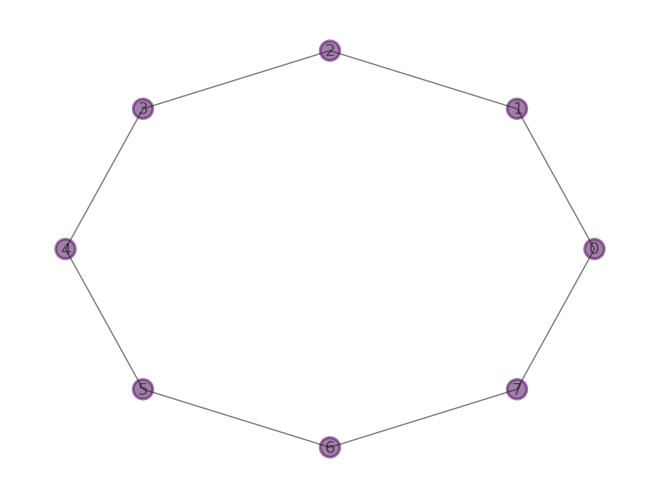

This is the config: [-1, -1, -1, -1, -1, -1, -1, -1]
This is the energy: 7.2
This is the Gibbs: 5.380186160021138e-32
This is the config: [-1, -1, -1, -1, -1, -1, -1, 1]
This is the energy: 3.4
This is the Gibbs: 1.713908431542013e-15
This is the config: [-1, -1, -1, -1, -1, -1, 1, -1]
This is the energy: 3.4
This is the Gibbs: 1.713908431542013e-15
This is the config: [-1, -1, -1, -1, -1, -1, 1, 1]
This is the energy: 3.6
This is the Gibbs: 2.319522830243569e-16
This is the config: [-1, -1, -1, -1, -1, 1, -1, -1]
This is the energy: 3.4
This is the Gibbs: 1.713908431542013e-15
This is the config: [-1, -1, -1, -1, -1, 1, -1, 1]
This is the energy: -0.4
This is the Gibbs: 54.598150033144236
This is the config: [-1, -1, -1, -1, -1, 1, 1, -1]
This is the energy: 3.6
This is the Gibbs: 2.319522830243569e-16
This is the config: [-1, -1, -1, -1, -1, 1, 1, 1]
This is the energy: 3.8
This is the Gibbs: 3.139132792048052e-17
This is the config: [-1, -1, -1, -1, 1, -1, -1, -1]
This is the energy

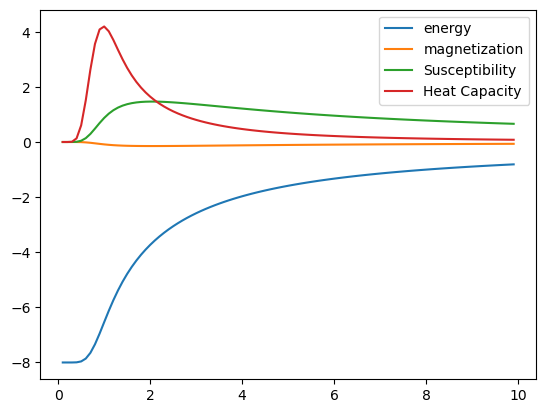

In [6]:
N = 8

# Initialize lists that we will fill with the property vs. temperature data
e_list = []
e2_list = []
m_list = []
m2_list = []
T_list = []

# Create BitString
conf = montecarlo.BitString(N=N)
print(" Number of configurations: ", conf.n_dim)

# Define a new hamiltonian values
G = build_1d_graph(N, 1)
draw_my_graph(G, conf)
ham = get_IsingHamiltonian(G, mus=[.1 for i in range(N)])



for Ti in range(1,100):
    T = .1*Ti
    
    E, M, HC, MS = ham.compute_average_values(conf, T)
    
    e_list.append(E)
    m_list.append(M)
    e2_list.append(HC)
    m2_list.append(MS)
    T_list.append(T)


plt.plot(T_list, e_list, label="energy");
plt.plot(T_list, m_list, label="magnetization");
plt.plot(T_list, m2_list, label="Susceptibility");
plt.plot(T_list, e2_list, label="Heat Capacity");
plt.legend();

Tc_ind = np.argmax(m2_list)
print(" Critical Temperature: %12.8f " %(T_list[Tc_ind]))
print("     E:  %12.8f" %(e_list[Tc_ind]))
print("     M:  %12.8f" %(m_list[Tc_ind]))
print("     HC: %12.8f" %(e2_list[Tc_ind]))
print("     MS: %12.8f" %(m2_list[Tc_ind]))
Tc2 = T_list[np.argmax(e2_list)]
print(" Critical Temperature: %12.8f" %(Tc2))

print(" E = %12.8f @ T = %12.8f"% (e_list[T_list.index(2.00)], 2.0))


# Metropolis Sampling

These exact calculations pose a drastic problem from a practical perspective. As `N` becomes large it is evident that computations become a daunting task if calculated in this manner. Thus a better numerical alternative would be to use a simulation to generate data over the ‘representative states’. Because each computed value of a configuration gets weighted by it's probability, very high energy states (which have negligible probabilities due to the Boltzmann distribution) will not contribute to the overall sum. What we'd like to do instead, is to sample over *only* those configurations that actively contribute. This is a form of biased sampling which essentially boils down to satisfying the following condition where

**generated frequency = actual probability**.

We could choose to randomly `sample` from this full set of configurations, but this will not converge quickly. By randomly sampling, we simply mean to pick a configuration, $\alpha$, at random, where all configurations have equal probability of being selected. However, what if we *knew* a priori what the equilibrium probability distribution was? Then we could select configurations not randomly, but rather where a given configurations probability of being selected was proportional to its equilibrium population,

$$
\frac{1}{Z}e^{-E(\alpha)/T}.
$$

If each configuration had the thermodynamic probability of being sampled, then our average value would reduce to a simple arithmetic average over the samples:

$$
\left<A\right> = \frac{1}{M} \sum_\alpha A(\alpha).
$$

How can we carry out this fancy, biased sampling? - Markov process! We will *walk* randomly through configuration space. Each configuration that we visit we will compute properties that contribute to our average values. From each we visit, we will consider a new randomly chosen configuration and decide whether or not to visit that new configuration. The rules we use to determine whether or not to visit a new configuration will be chosen to guarantee that the number of times we visit a configuration is exactly proportional to the equilibrium population of that configuration!

The choice to visit a new configuration will be made probabilistically. Assume we are currently visiting configuration $\alpha$. We select configuration $\beta$ at random, and want to decide whether or not to visit $\beta$. If the $\beta$ is lower in energy than $\alpha$, then we will visit the new configuration with 100% probability, 

$$
W(\alpha\rightarrow\beta)=1.
$$

If the $\beta$ is *higher* in energy, then we will visit the new configuration with a probability given by,

$$
W(\alpha\rightarrow\beta)=e^{-\left(E(\beta)-E(\alpha)\right)/T}.
$$

This seems simple, but it's quite powerful! We want to use this to make our simulations much faster, at the cost of some statistical noise.


	1. Initialize configuration, α
	2. Loop over Monte Carlo steps	    
		1. Loop over sites, i
			1. Propose new configuration, β, by flipping site, i.
			2. Compute flipping probability, W(α→β). 
			3. If a randomly chosen number between 0 and 1 is less than W(α→β), 
					Accept β (α = β), 
				else: 
					Reject β  
		2. Update average values with updated α

----


In [7]:
# Initialize BitString

conf = montecarlo.BitString(N=N)
conf.initialize(M=4)

# run montecarlo
E, M, EE, MM = montecarlo.IsingHamiltonian.metropolis_montecarlo(ham, conf, T=2, nsweep=8000, nburn=2000)

    
HC = (EE[-1] - E[-1]*E[-1])/T/T
MS = (MM[-1] - M[-1]*M[-1])/T
print("     E:  %12.8f" %(E[-1]))
print("     M:  %12.8f" %(M[-1]))
print("     HC: %12.8f" %(HC))
print("     MS: %12.8f" %(MS))
# Exact values
# E:   -3.73231850
# M:    0.14658168
# EE:   1.64589165
# MM:   1.46663062
    
plt.plot(E, label="energy");
plt.plot([-3.73231850]*len(E), label="exact");
plt.legend();

# Eexact, M, HC, MS = ham1d.compute_average_values(conf, 2)
# print(Eexact)
# Eexact, M, HC, MS = ham.compute_average_values(conf, 2)
# print(Eexact)




[ 1  1  1  1 -1  1 -1  1]


TypeError: IsingHamiltonian.metropolis_montecarlo() got an unexpected keyword argument 'T'

# Energy/Magnetization vs Temperature (Metropolis Sampling)

In [ ]:
def run_T_scan(ham, conf, Tstep=.1, Tmax=10, n_mc_steps=2000, n_burn=200):
    
    N = len(conf.config)
    if len(ham.J) != N:
        error("dimensionMismatch")

    T_range = []
    e_vs_T = []
    m_vs_T = []
    ee_vs_T = []
    mm_vs_T = []
    heat_cap_vs_T = []
    magn_sus_vs_T = []
    
    T = 1*Tstep
    for Ti in range(int(Tmax/Tstep)):
        T += Tstep
        conf = montecarlo.BitString(N=N)
        conf.initialize(M=int(N/2))
        # E, M, HC, MS = compute_montecarlo(ham, conf, T, n_mc_steps, n_burn, plot=False)
        e, m, ee, mm = montecarlo.metropolis_montecarlo(ham, conf, T=T, nsweep=n_mc_steps, nburn=n_burn)

        
        T_range.append(T)

        e_vs_T.append(e[-1])
        m_vs_T.append(m[-1])
        ee_vs_T.append(ee[-1])
        mm_vs_T.append(mm[-1])

        E  = e[-1]
        EE = ee[-1]
        M  = m[-1]
        MM = mm[-1]
        heat_cap = (EE-E*E)/(T*T)
        magn_sus = (MM-M*M)/T
        heat_cap_vs_T.append(heat_cap)
        magn_sus_vs_T.append(magn_sus)

        # print("T= %12.8f E= %12.8f M=%12.8f Heat Capacity= %12.8f Mag. Suscept.=%12.8f" %(T, e[-1], m[-1], heat_cap, magn_sus))

    plt.plot(T_range,e_vs_T, label="Energy")
    plt.plot(T_range,m_vs_T, label="Magnetization")
    plt.plot(T_range,magn_sus_vs_T, label="Susceptibility")
    plt.plot(T_range,heat_cap_vs_T, label="Heat Capacity")
    plt.legend()




In [ ]:
run_T_scan(ham, conf, Tstep=.1, Tmax=10, n_mc_steps=100, n_burn=10)

In [ ]:
run_T_scan(ham, conf, Tstep=.1, Tmax=10, n_mc_steps=500, n_burn=100)

In [ ]:
run_T_scan(ham, conf, Tstep=.1, Tmax=10, n_mc_steps=1000, n_burn=100)

In [ ]:
run_T_scan(ham, conf, Tstep=.1, Tmax=10, n_mc_steps=2000, n_burn=200)

In [ ]:
run_T_scan(ham, conf, Tstep=.1, Tmax=10, n_mc_steps=10000, n_burn=1000)

# Larger graph

In [ ]:
N = 100
Jval = 1
G = build_1d_graph(N, Jval)
for i in range(N):
    G.add_edge(i, (i+30) % N, weight=.2)


# Now Draw the graph. First we will draw it with the nodes arranged on the circle, then we will draw the same graph 
# with the position of the nodes optimized for easier visualization. Let's make a function for this

ham = get_IsingHamiltonian(G, mus=[.1 for i in range(N)])
conf = montecarlo.BitString(N=N)
conf.initialize(M=25)
e, m, ee, mm = montecarlo.metropolis_montecarlo(ham, conf, T=T, nsweep=5000, nburn=1000)
print("%12.8f" %e[-1])
# plt.plot(e, label="energy");
# plt.legend();
draw_my_graph(G, conf, circ=True)
draw_my_graph(G, conf, circ=False)


In [ ]:
run_T_scan(ham, conf, Tstep=.1, Tmax=10, n_mc_steps=10000, n_burn=1000)


In [ ]:
draw_my_graph(G, conf, circ=True)
draw_my_graph(G, conf, circ=False)

In [ ]:
nx.draw(G, pos=nx.bipartite_layout(G, np.where(conf.config == 0)[0]), node_size=1)